In [37]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

In [38]:
def printest(args, value):
    return print( "{} : \n {} \n".format(args, value) )

In [39]:
df = pd.read_csv('Data/data_car_price.csv')

display(df.head(3))
printest('total cars (rows)', len(df))

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350


total cars (rows) : 
 11914 



This dataset overview reveals some inconsistencies, such as column names containing spaces or underscores ( _ ), and varying capitalization and spacing within feature values. To address these issues and enhance clarity, we can normalize the data by replacing all spaces with underscores and converting all letters to lowercase.

In [53]:
# Columns

# .str transform each element into string
# .str != String()
df_columns_lower = df.columns.str.lower()
df.columns  = df_columns_lower.str.replace(' ', '_')

# Rows

# boolean mask
mask = df.dtypes == 'object'
# keep the values in witch mask = True
filter = df.dtypes[mask].index
string_columns = list(filter)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.head(3)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350


This dataset contains multiple columns (features):

- **make**: The car's brand (e.g., BMW, Toyota, etc.)
- **model**: The car's specific model
- **year**: The manufacturing year of the car
- **engine_fuel_type**: The type of fuel required by the engine (e.g., diesel, electric, etc.)
- **engine_hp**: The engine's horsepower
- **engine_cylinders**: The number of engine cylinders
- **transmission_type**: The type of transmission (automatic or manual)
- **driven_wheels**: Front, rear, or all-wheel drive
- **number_of_doors**: The number of doors in the car
- **market_category**: Market segment (e.g., luxury, crossover, etc.)
- **vehicle_size**: The size classification (compact, midsize, or large)
- **vehicle_style**: The body style (e.g., sedan or convertible)
- **highway_mpg**: Fuel efficiency on the highway (measured in miles per gallon)
- **city_mpg**: Fuel efficiency in the city (measured in miles per gallon)
- **popularity**: The number of times the car was mentioned in a Twitter stream
- **msrp**: The manufacturer's suggested retail price

Our primary focus in this dataset is the **MSRP** column, which represents the car's price. We will use this column to predict car prices.

## Exploratory Data Analysis (EDA)

The MSRP column holds crucial data, as it represents our target variable, the 'y', which is the value we aim to predict accurately.

A vital initial step in exploratory data analysis is examining the distribution of 'y'. By doing so, we gain insight into the possible values of 'y' and their frequency of occurrence. This visualization is commonly referred to as a histogram, which effectively conveys the distribution of our target variable.

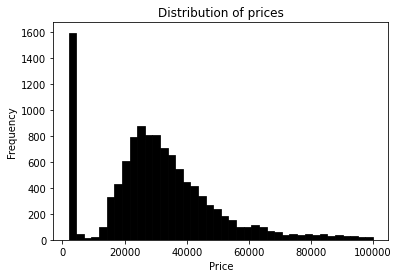

In [59]:
plt.figure(figsize=(6, 4))

sns.histplot(df.msrp[df.msrp < 1e5], bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

By taking a closer look at values below $10^5$, we can observe the distribution more closely. There are numerous cars with lower prices on the left side of the histogram, but the count drops off rapidly, leaving a long tail of cars with high prices. This long-tail distribution is a common occurrence in situations where many items have low prices, while only a few are expensive.

Visualizing the long-tail distribution can be challenging due to the extreme values that make it difficult to discern the shape of the distribution. Training a model on this type of data can also be problematic, as the distribution may cause confusion for the model, hindering its ability to learn the important features effectively.

To solve this problem we can make a transformation in the values by applying a log function. The log function has a nice property of transforming large values into smaller ones while maintaining the relative differences between the original values. This transformation can help make skewed distributions more manageable for visualization and analysis. Consider the following transformation:

$$y_{new} = log(x+1)$$

the $+1$ part is important in cases that have zeros.

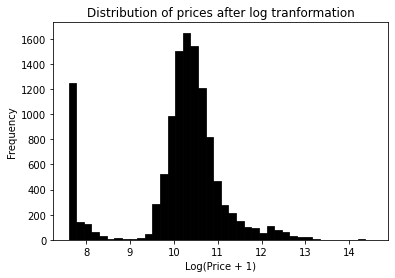

In [60]:
log_price = np.log1p(df.msrp)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

In [61]:
# Checking for missing values at other features

df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

A few columns have missing values. Market_category is the most affected one, in which we have
almost 4,000 rows with missing values.

## Data Validation

In [72]:
n = len(df)
n_val = int(0.2*n)   # 20% for validation
n_test = int(0.2*n)  # 20% for test
n_train = int(0.6*n) # 60% for train

# shuffle indices
np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)
# subset rows by indices
df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

# original values from the target
y_train_orig = df_train.msrp.values
y_val_orig = df_val.msrp.values
y_test_orig = df_test.msrp.values

# apply the log transformation in original values
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

# To avoid accidentally using the target variable
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']


## Linear Regression

Consider a hypothetical dataset with multiple attributes and a target variable as shown:

$$\mathbf{X} =
\left( \begin{array}{c|cccc|c}
~    &X_{0}&X_{1}&\cdots & X_{n_0}  & Y\\
\hline
x_{1} &1& x_{11}& \cdots&x_{1n_0}&y_1 \\
\vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
x_{n}&1&x_{n1}&\cdots&x_{nn_0}&y_n
\end{array} \right).$$

Each row vector $\vec{x}_1, \cdots, \vec{x}_n$ has $n+1$ features:

$$\vec{x}_i = (x_{1i}, \cdots, x_{ni})^T$$

The linear regression for multiple attributes $X_{1},\cdots, X_{n_0}$ can be represented as:

$$\vec{\hat{Y}} = \vec{W}\mathbf{X} $$

Here, $\mathbf{W} = (w_o,\cdots, w_d)$ denotes the weights that the model seeks to learn for an optimal regression. $\vec{\hat{Y}}$ represents the predicted values, and $\vec{Y}$ stands for the true values (or target values). The error function commonly used is the sum of squared errors (SSE):

$$\text{SSE} = \sum_{i}^{n} ||{\epsilon}_i||^2 = \vec{\epsilon}\vec{\epsilon}^T$$

where $\vec{\epsilon} = \vec{\hat{Y}} - \vec{Y}$.

Rearranging the error function gives:

$$
\begin{align*}
\text{SSE} &= (\vec{\hat{Y}} - \vec{Y})^T(\vec{\hat{Y}} - \vec{Y})\\
&=\vec{Y}^T \vec{Y}  - 2\vec{Y}^T \vec{\hat{Y}} + \vec{\hat{Y}}^T \vec{\hat{Y}}\\
&=\vec{Y}^T \vec{Y}  - 2\vec{Y}^T  (\vec{W}\mathbf{X}) + ( \vec{W}\mathbf{X})^T ( \vec{W}\mathbf{X})\\
&=\vec{Y}^T \vec{Y}  - 2 \vec{W}^T (\mathbf{X}^T\vec{Y}) + \vec{W}^T( \mathbf{X}\mathbf{X}^T) \vec{W}
\end{align*}
$$

The goal is to minimize this error to optimize the ideal weights. Instead of using gradient descent, we take the derivative of the SSE with respect to the weights, set it equal to zero, and find a local minimum of the SSE function. This leads to the following optimal weights for the optimization problem:

$$
\begin{align*}
\frac{\partial (\text{SSE})}{\partial \vec{W}} & = -2\mathbf{X}^T\vec{Y} + (\mathbf{X}^T\mathbf{X})\vec{W} + \vec{W}^T(\mathbf{X}^T\mathbf{X})\\
& = -2\mathbf{X}^T\vec{Y} + 2(\mathbf{X}^T\mathbf{X})\vec{W} = 0
\end{align*}
$$

Solving for the optimal weights, we get the following analytical solution:

$$\vec{W} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\vec{Y}$$

In summary, for a given dataset with multiple attributes, we can represent the linear regression model as a product of weights and input features. The objective is to minimize the sum of squared errors (SSE) to find the optimal weights for the model. By taking the derivative of the SSE with respect to the weights and setting it to zero, we can determine the optimal weights for the optimization problem using the above equation. This concept can be translated into Python code as follows:

In [73]:
def linear_regression(X, y):
    # adding ones in the dataset X
    X_0 = np.ones(X.shape[0])
    X = np.column_stack([X_0, X])


    XTX = X.T.dot(X)
    XTX_inverse = np.linalg.inv(XTX)
    w = XTX_inverse.dot(X.T).dot(y)
    
    return w[0], w[1:]

## Baseline solution

We will start with a simple method for feature creation by selecting a few numerical features and constructing the matrix $X$ using these features. Additionally, we will handle missing values by filling them with a substitute value. The most basic approach is to fill the missing values with zeros. Although this may not be the best way to deal with missing values, it is often sufficient. By setting the missing feature value to zero, the respective feature is effectively ignored.

In [84]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

def prepare_X(df):
    # select numerical columns
    df_num = df[base]
    # nan to zeros
    df_num = df_num.fillna(0)
    # return only features array
    X = df_num.values
    return X

X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

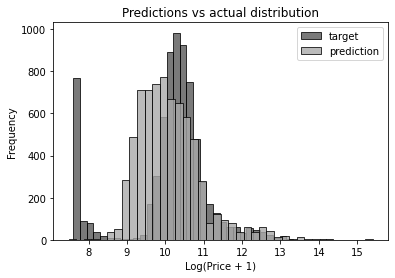

In [79]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

From the plot, we observe that the distribution of predicted values significantly differs from the actual values. This outcome suggests that the model might not be sufficiently robust to capture the target variable's distribution.

Lets calculate the error function. A lower SSE value indicates a better fit of the model to the data.Also SSE is sensitive to the scale of the target variable, so it may be more informative to use a normalized metric such as mean squared error (MSE) or root mean squared error (RMSE) for comparison purposes.

let's compare each one and see in pratics the results:

In [85]:
def mse_sse_rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    sse = np.sum(error ** 2)
    rmse = np.sqrt(mse)
    return mse, sse, rmse

# for training set
mse, sse, rmse  = mse_sse_rmse(y_train, y_pred)
print("Train Dataset")
printest('mse:', mse )
printest('sse:', sse)
printest('rmse:', rmse)

Train Dataset
mse: : 
 0.5707185661356206 

sse: : 
 4079.496310737416 

rmse: : 
 0.7554591756909307 



In [86]:
# for validation set
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
mse, sse, rmse = mse_sse_rmse(y_val, y_pred)
print("\nValidation Dataset")
printest('mse:', mse )
printest('sse:', sse)
printest('rmse:', rmse)


Validation Dataset
mse: : 
 0.5803845734290475 

sse: : 
 1382.4760539079912 

rmse: : 
 0.7618297535729669 



The difference in the magnitude of these error metrics is because MSE and RMSE are average values, whereas SSE is the sum of all squared errors. The larger the dataset, the larger the SSE will be in comparison to the MSE and RMSE.

## Simple feature engineering